## Multi-class SVM Image Classifier


### Importing required libraries

In [37]:
import random
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import platform

In [38]:
# ipynb parameters

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# funcs to load datasets

def load_pickle(f):
    version = platform.python_version_tuple()

    if version[0] == "2":
        return pickle.load(f)
    elif version[0] == "3":
        return pickle.load(f, encoding="latin1")

    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):

    with open(filename, "rb") as f:
        datadict = load_pickle(f)
        X = datadict["data"]
        Y = datadict["labels"]
        X = X.reshape(10000, 3, 32, 32).transpose(0, 2, 3, 1).astype("float")
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(dataset_path):    
    xs, ys = [], []

    for batch_id in range(1, 6):
        f = os.path.join(dataset_path, "data_batch_%d" % (batch_id,))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)

    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)

    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(dataset_path, "test_batch"))

    return Xtr, Ytr, Xte, Yte

In [40]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/cifar-10-batches-py'
train_data_x, train_data_y, test_data_x, test_data_y = load_CIFAR10(cifar10_dir)

print('Training data shape: ', train_data_x.shape)
print('Training labels shape: ', train_data_y.shape)
print('Test data shape: ', test_data_x.shape)
print('Test labels shape: ', test_data_y.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


### Visualizing the dataset

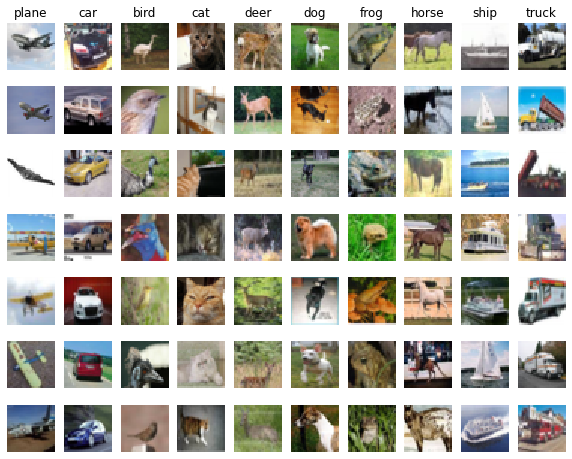

In [41]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_data_y == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_data_x[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

### Splitting dataset to train, validation and test

In [42]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# splitting training data
x_train = train_data_x[:num_training]
y_train = train_data_y[:num_training]

# splitting validation data
x_val = train_data_x[num_training:]
y_val= train_data_y[num_training:]

# splitting a development set, a small subset of
# the training set for faster training
rand_indices = np.random.choice(num_training, num_dev, replace=False)
x_dev = x_train[rand_indices]
y_dev = y_train[rand_indices]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
x_test = test_data_x[mask]
y_test = test_data_y[mask]

print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', x_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


### Preprocessing the images array

In [43]:
# Reshaping image data into arrays
x_train = np.reshape(x_train, (x_train.shape[0], -1))
x_val = np.reshape(x_val, (x_val.shape[0], -1))
x_test = np.reshape(x_test, (x_test.shape[0], -1))
x_dev = np.reshape(x_dev, (x_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', x_train.shape)
print('Validation data shape: ', x_val.shape)
print('Test data shape: ', x_test.shape)
print('Dev data shape: ', x_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
Dev data shape:  (500, 3072)


In [44]:
# # Preprocessing: subtract the mean image
# # first: compute the image mean based on the training data
# mean_image = np.mean(x_train, axis=0)
# print(mean_image[:10]) # print a few of the elements
# plt.figure(figsize=(4,4))
# plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
# plt.show()

# # second: subtract the mean image from train and test data
# x_train -= mean_image
# x_val -= mean_image
# x_test -= mean_image
# x_dev -= mean_image

### Adding bias dimension to features for easier computation

In [45]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
x_train = np.hstack([x_train, np.ones((x_train.shape[0], 1))])
x_val = np.hstack([x_val, np.ones((x_val.shape[0], 1))])
x_test = np.hstack([x_test, np.ones((x_test.shape[0], 1))])
x_dev = np.hstack([x_dev, np.ones((x_dev.shape[0], 1))])

print(x_train.shape, x_val.shape, x_test.shape, x_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## *SVM Classifier*

In [51]:
import numpy as np

class LinearSVMClassifier(object):
    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100, batch_size=200, verbose=False):
        """
        Train this linear classifier using stochastic gradient descent.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.

        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = (np.max(y) + 1)  # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            # creating an array of random indices
            indices = np.random.choice(num_train, batch_size, replace=True)

            # creating mini batches of training dataset
            X_batch, y_batch = X[indices], y[indices] 

            # evaluate loss and gradient
            loss, grad = self.loss_vectorized(self.W, X_batch, y_batch, reg)
            loss_history.append(loss)
            
            # updating the weights
            self.W -= learning_rate * grad

            if verbose and it % 100 == 0:
                print("iteration %d / %d: loss %f" % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.

        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.

        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[0])
        y_pred = X.dot(self.W).argmax(axis = 1) 
        return y_pred
    
    def loss_naive(self, W, X, y, reg):
        """
        Structured SVM loss function, naive implementation (with loops).

        Inputs dimension -> D
        Classes -> C
        Mini-batchsize -> N

        Inputs:
        - W: np array of shape (D, C) containing weights.
        - X: np array of shape (N, D) containing a minibatch of data.
        - y: np array of shape (N,) containing training labels; y[i] = c means
            that X[i] has label c, where 0 <= c < C.
        - reg: (float) regularization strength

        Returns: (loss, gradients)
        - loss -> single float
        - gradient with respect to weights W; same shape as W
        """
        dW = np.zeros(W.shape)  # initialize the gradient as zero

        # compute the loss and the gradient
        num_classes = W.shape[1]
        num_train = X.shape[0]
        loss = 0.0

        for i in range(num_train):
            scores = X[i].dot(W)
            correct_class_score = scores[y[i]]

            for j in range(num_classes):

                if j == y[i]:                    
                    continue

                margin = scores[j] - correct_class_score + 1  # note delta = 1
                if margin > 0:
                    loss += margin
                    
                    # for incorrect class i.e j != y[i], gradient for jth class is
                    # X * I (For margin > 0). We add it to the jth column of gradient matrix
                    # (dw) by incrementing it with the column vector of the input array (flattend ver of image).
                    dW[:, j] += X[i].T
                    
                    # for correct class i.e j == y[i], gradient for jth class is
                    # -X * I (For margin > 0). We add it to the y[i]th column of gradient matrix
                    # (dw) by incrementing it with the column vector of the input array (flattend ver of image).
                    dW[:, y[i]] += -X[i].T

        # Right now the loss is a sum over all training examples, but we want it
        # to be an average instead so we divide by num_train.
        average_loss = loss / num_train

        # Add regularization to the loss.
        regularized_loss = average_loss + reg * np.sum(W * W)

        # taking the average of the gradients
        average_dW = dW / num_train

        # adding regularization loss to the gradient matrix
        regularized_dW = average_dW + (2 * reg * W)  

        return regularized_loss, regularized_dW


    def loss_vectorized(self, W, X, y, reg):
        """
        Structured SVM loss function, vectorized implementation.

        Inputs dimension -> D
        Classes -> C
        Mini-batchsize -> N

        Inputs:
        - W: np array of shape (D, C) containing weights.
        - X: np array of shape (N, D) containing a minibatch of data.
        - y: np array of shape (N,) containing training labels; y[i] = c means
            that X[i] has label c, where 0 <= c < C.
        - reg: (float) regularization strength

        Returns: (loss, gradients)
        - loss -> single float
        - gradient with respect to weights W; same shape as W
        """
        loss = 0.0
        dW = np.zeros(W.shape)  # initialize the gradient as zero


        # compute the loss 
        num_classes = W.shape[1]
        num_train = X.shape[0]
        loss = 0.0
        scores = X.dot(W) #dims: N x C    

        # fetching correct class scores and traforming into column vect
        correct_class_scores = scores[np.arange(num_train), y].reshape(-1, 1)

        # computing hinge loss
        margin = np.maximum(0, scores - correct_class_scores + 1) # note delta = 1
        # set the loss for correct classes to be 0
        margin = np.where(margin == 1.0, 0 , margin)

        # loss is summed over all training data and classes 
        loss = np.sum(margin)
        # average the loss for the whole dataset
        average_loss = loss / num_train
        # regularize the loss using the Weights sq
        regularized_loss = average_loss + reg * np.sum(W * W)

        # compute the gradient loss
        # compute input mask
        valid_margin_mask = np.zeros(margin.shape) # margin.shape is N x C
        valid_margin_mask[margin > 0] = 1 # if margin is positive, set a positive mask

        # subtract in correct class (-s_y) aka valid_margin_count
        valid_margin_mask[np.arange(num_train), y] = -np.sum(valid_margin_mask, axis=1)

        # computing gradients by using valid_margin_mask as a function
        # X.T x valid_margin_mask = (D x N) x (N x C) = D x C
        dW = X.T.dot(valid_margin_mask)

        # averaging gradients for whole dataset
        average_dW = dW / num_train

        # regularizing the gradients using weights
        regularized_dW = average_dW + (2 * reg * W)   

        return regularized_loss, regularized_dW

### Testing multiclass SVM loss function

1. Naive Method

In [47]:
svm = LinearSVMClassifier()

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm.loss_naive(W, x_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.989866


2. Vectorized Method

In [48]:
svm = LinearSVMClassifier()

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm.loss_vectorized(W, x_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.011510


### Comparing Both loss func methods

In [49]:
import time

svm = LinearSVMClassifier()

t1 = time.time()
loss_naive, grad_naive = svm.loss_naive(W, x_dev, y_dev, 0.000005)
t2 = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, t2 - t1))

t1 = time.time()
loss_vectorized, grad_vectorized = svm.loss_vectorized(W, x_dev, y_dev, 0.000005)
t2 = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, t2 - t1))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss: %f' % (loss_naive - loss_vectorized))
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference in gradients: %f' % difference)

Naive loss: 9.011510e+00 computed in 0.145181s
Vectorized loss: 9.011510e+00 computed in 0.009800s
difference in loss: 0.000000
difference in gradients: 0.000000


### Training the SVM model using loss func

In [52]:
svm = LinearSVMClassifier()

t1 = time.time()
loss_hist = svm.train(x_train, y_train, learning_rate=1e-7, reg=2.5e4, num_iters=1500, verbose=True)
t2 = time.time()

print('That took %fs' % (t2 - t1))

TypeError: loss_vectorized() missing 1 required positional argument: 'reg'